# Unsupervised learning for time series

On this notebook I tried to use some clusterization techniques that would allow me to cluster time series. Specifically, I'll cluster some countries according to their GDP per capita (adjusted by power purchase parity measured on constant 2010 USD), their unemployment rate and their inflation rate (Laspeyres index). As a result, each cluster to which each country belongs could be represented by a tuple of three time series, that I would call representative pathways and that are the euclidean barycenter of the time series collection within each cluster.

In [1]:
import pandas as pd
import numpy as np

from itertools import combinations, product

from fastdtw import fastdtw
from scipy.spatial.distance import canberra
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

from tslearn.barycenters import euclidean_barycenter

from functools import partial, reduce

from matplotlib import pyplot as plt
%matplotlib inline

## Data preprocessing

I preprocessed the csv file downloaded from WorldBank's databank. The csv file is transformed from a wide format to a long format, which is easier to manipulate. 

In [2]:
df = pd.read_csv('data/world_bank_index.csv')

index_row = df.iloc[:,0].isin(['GDP per capita, PPP (constant 2017 international $)', 
                           'Unemployment, total (% of total labor force) (modeled ILO estimate)',
                           'Inflation, consumer prices (annual %)'])
index_col = df.columns.isin(['Series Name', 'Country Name', 
                             '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
                             '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
                             '2008 [YR2008]', '2009 [YR2009]', '2010 YR2010]', '2011 [YR2011]',
                             '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]'])
df = df.loc[index_row, index_col].copy()

df = pd.melt(df, id_vars=['Series Name', 'Country Name']).copy()
df['variable'] = df['variable'].apply(lambda x: x.split(' ')[0]).astype(np.int64)
df['value'] = df['value'].apply(lambda x: None if x == '..' else float(x))
df['Series Name'] = df['Series Name'].apply(lambda x: x.split(' ')[0].replace(',', ''))
df = pd.pivot_table(df, values='value', index=['Country Name', 'variable'], columns=['Series Name']).reset_index().copy()

df.rename(columns={'Country Name': 'Country', 'variable': 'Year'}, inplace = True)

max_null = 13
df_nulls = df.groupby('Country').apply(lambda x: x[['GDP', 'Inflation', 'Unemployment']].isnull().sum())
countries_nonull = list(df_nulls.index[(df_nulls['GDP'] <= max_null) & 
                                       (df_nulls['Inflation'] <= max_null) & 
                                       (df_nulls['Unemployment'] <= max_null)])

df = df[df['Country'].isin(countries_nonull)].copy()

## Train and test sets

The countries are divided into a train set and a test set. This would help us to illustrate how to clusterize withing a smaller group, so that it is not required to have the entire dataset in memory, to then scale the entire clusterization onto the entire sample.

In [3]:
ratio_train = 0.4
countries = df.Country.unique()

len_train = round(len(countries)*ratio_train)
countries_train = np.random.choice(countries, len_train, False)
countries_test = [country for country in countries if country not in countries_train]

## Compute distances

Then, this function allow us to compute the distance amongst every pair of tuples (GDP, inflation and unemployment). Note that I used canberra distance, but it could be any other one, such as manhattan, mahalanobis, euclidean or minkowski's distance.

In [4]:
comb = combinations(countries_train, 2)
list_comb = list(comb)
 
def distance_between_countries(countries_ab, df1 = df, df2 = None, type_dist = canberra):
    country_a, country_b = countries_ab
    
    if df2 is None:
        df2 = df1
    
    arr_a = df1.loc[df1['Country'] == country_a, df1.columns.isin(['Year', 'GDP', 'Inflation', 'Unemployment'])].T.to_numpy()
    arr_a = np.array(arr_a, dtype = 'float64')
    arr_a = (arr_a - np.mean(arr_a, axis=1).reshape(4,1))/np.std(arr_a, axis = 1).reshape(4,1)
    
    arr_b = df2.loc[df2['Country'] == country_b, df2.columns.isin(['Year', 'GDP', 'Inflation', 'Unemployment'])].T.to_numpy()
    arr_b = np.array(arr_b, dtype = 'float64')
    arr_b = (arr_b - np.mean(arr_b, axis=1).reshape(4,1))/np.std(arr_b, axis = 1).reshape(4,1)
    
    try:
        distance, _ = fastdtw(arr_a, arr_b, dist=type_dist)
    except:
        distance = None
        
    return country_a, country_b, distance

mapped_distances = map(distance_between_countries, list_comb)

df_distances = pd.DataFrame(mapped_distances, columns = ['country_a', 'country_b', 'distance'])
df_distances.fillna(df_distances.max(axis = 0), inplace = True)

## Initial hierarchical clustering

Using those distances computed for every pair of countries wihtin out training sample, I clustered initially by using a hierarchical clustering algorithm. Note that I used ward linkage, but it could be any other likage method such as complete, mean, median, etc.

In [5]:
df_distances = df_distances.sort_values(['country_a', 'country_b'])
linkage_matrix = linkage(df_distances.distance, 'ward', 'euclidean')

Also, I plotted a dendrogram so that it were easier to find an iniatial number of clusters.

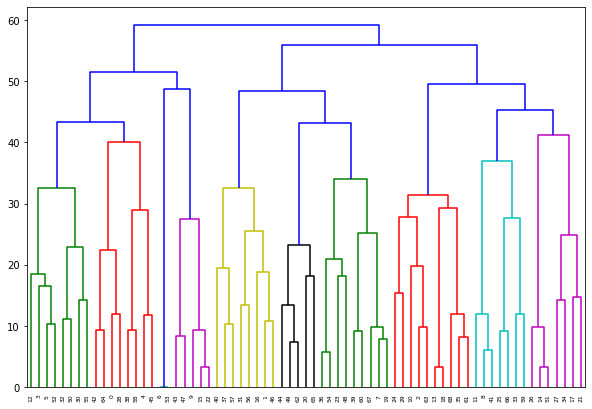

In [6]:
plt.figure(figsize=(10,7))
dendrogram(linkage_matrix,
          orientation='top',
          distance_sort='descending',
          show_leaf_counts=True
          )
plt.show()

In [7]:
k = 9

ids = df_distances['country_a'].append(df_distances['country_b']).drop_duplicates()
df_clusters = pd.DataFrame({'Country':ids, 'Cluster': fcluster(linkage_matrix, k, criterion='maxclust')})

## First barycenter

However, as I computed the barycenter of each cluster with the function implemented here, I found that each pathway did not seem to be clearly separated from the others

In [8]:
def barycenters(df, df_clusters):

    df_unlist = df.pivot_table(['GDP', 'Inflation',  'Unemployment'], ['Country'], ['Year']).fillna(0)

    df_GDP = df_unlist['GDP'].merge(df_clusters, on = 'Country')
    df_unemployment = df_unlist['Unemployment'].merge(df_clusters, on = 'Country')
    df_inflation = df_unlist['Inflation'].merge(df_clusters, on = 'Country')

    df_grouped_bary_GDP = df_GDP.drop(columns = ['Country']).groupby('Cluster')
    df_bary_GDP = df_grouped_bary_GDP.apply(lambda x:  euclidean_barycenter(x.drop(columns = 'Cluster').to_numpy()))
    GDP_series = df_bary_GDP.apply(lambda x: np.concatenate(x))
    df_bary_GDP = pd.DataFrame(GDP_series.values.tolist(), index=GDP_series.index)

    df_grouped_bary_unemployment = df_unemployment.drop(columns = ['Country']).groupby('Cluster')
    df_bary_unemployment = df_grouped_bary_unemployment.apply(lambda x:  euclidean_barycenter(x.drop(columns = 'Cluster').to_numpy()))
    unemployment_series = df_bary_unemployment.apply(lambda x: np.concatenate(x))
    df_bary_unemployment = pd.DataFrame(unemployment_series.values.tolist(), index=unemployment_series.index)

    df_grouped_bary_inflation = df_inflation.drop(columns = ['Country']).groupby('Cluster')
    df_bary_inflation = df_grouped_bary_inflation.apply(lambda x:  euclidean_barycenter(x.drop(columns = 'Cluster').to_numpy()))
    inflation_series = df_bary_inflation.apply(lambda x: np.concatenate(x))
    df_bary_inflation = pd.DataFrame(inflation_series.values.tolist(), index=inflation_series.index)
    
    return df_bary_inflation, df_bary_GDP, df_bary_unemployment

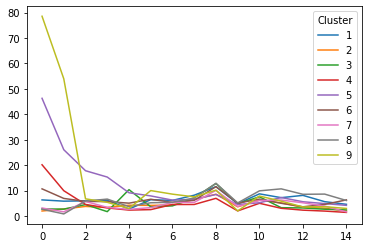

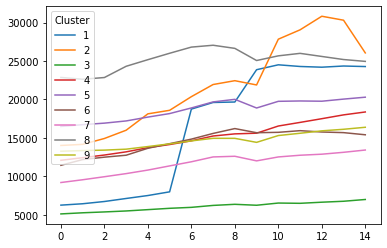

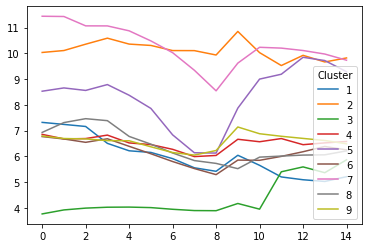

In [9]:
df_bary_inflation, df_bary_GDP, df_bary_unemployment = barycenters(df, df_clusters)

df_bary_inflation.T.plot()
df_bary_GDP.T.plot()
df_bary_unemployment.T.plot()

## EM schema

So, as a refinement, I proposed a simple expectation-maximization schema. Therefore, I simply computed the distance that each country had to each of the pathways, and the assigned each country to the closest pathway. With those new assignments, I would simply recalculted the barycenters (pathways) to repeat this procedure until the path ways between two consecutive iterations were not too different

In [10]:
def create_df_pathways(df_bary_GDP, df_bary_unemployment, df_bary_inflation, df):
    df_bary_GDP.columns = df['Year'].unique()
    df_bary_GDP = df_bary_GDP.reset_index().melt(['Cluster']).copy()

    df_bary_unemployment.columns = df['Year'].unique()
    df_bary_unemployment = df_bary_unemployment.reset_index().melt(['Cluster']).copy()

    df_bary_inflation.columns = df['Year'].unique()
    df_bary_inflation = df_bary_inflation.reset_index().melt(['Cluster']).copy()

    data_frames = [df_bary_GDP, df_bary_unemployment, df_bary_inflation]
    df_clusters = reduce(lambda  left,right: pd.merge(left, right, on=['Cluster', 'variable']), data_frames)
    df_clusters.columns = ['Country', 'Year', 'GDP', 'Unemployment', 'Inflation']
    
    return df_clusters

In [11]:
def find_cluster(Country, df_pathways):
    
    Country = [Country]
    clusters = df_pathways['Country'].unique()
    comb = product(Country, clusters)
    list_comb = list(comb)

    partial_distance_between_countries = partial(distance_between_countries, df1 = df, df2 = df_pathways)
    mapped_distances = map(partial_distance_between_countries, list_comb)
    
    try:
        min_dist = np.inf
        for _, cluster, distance in mapped_distances: 
            if distance < min_dist:
                min_dist = distance
                min_cluster = cluster

        return Country[0], min_cluster
    except:
        return Country[0], None

In [12]:
for i in range(1000):    
    df_pathways = create_df_pathways(df_bary_GDP, df_bary_unemployment, df_bary_inflation, df)
    partial_find_cluster = partial(find_cluster, df_pathways = df_pathways)
    df_clusters = pd.DataFrame(map(partial_find_cluster, countries_train), columns = ['Country', 'Cluster']).dropna()
    
    df_bary_inflation, df_bary_GDP, df_bary_unemployment = barycenters(df, df_clusters)

Finally, the results are plotted

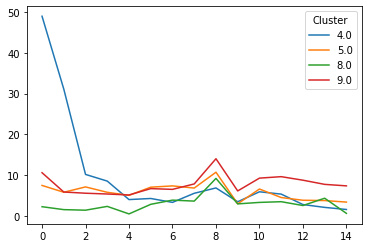

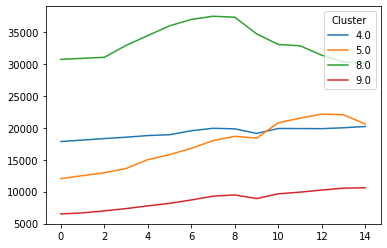

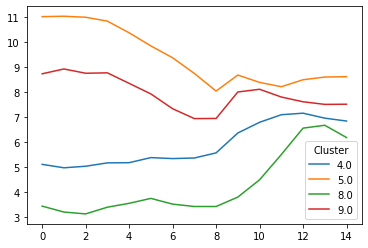

In [13]:
df_bary_inflation.T.plot()
df_bary_GDP.T.plot()
df_bary_unemployment.T.plot()